In [1]:
# this mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

# enter the foldername in your Drive where you have saved the unzipped
# assignment folder, e.g. 'cs231n/assignments/assignment3/'
FOLDERNAME = "deep-image-prior"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My drive/{}'.format(FOLDERNAME))

%cd drive/MyDrive/$FOLDERNAME/

Mounted at /content/drive
/content/drive/MyDrive/deep-image-prior


In [2]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import argparse
import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as np
from models import *
from models.unet import *

import torch
import torch.optim
import torchvision.transforms as transforms

# from skimage.measure import compare_psnr
from skimage.metrics import peak_signal_noise_ratio as compare_psnr
from models.downsampler import Downsampler

from utils.sr_utils import *
from utils.denoising_utils import *

import pickle

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
loss_type = nn.CrossEntropyLoss().cuda() if torch.cuda.is_available() else nn.CrossEntropyLoss()

In [3]:
train = torchvision.datasets.CIFAR10('data/Adversarial', download=True, train=True, transform=transforms.ToTensor())
val = torchvision.datasets.CIFAR10('data/Adversarial', train=False, transform=transforms.ToTensor())

Files already downloaded and verified


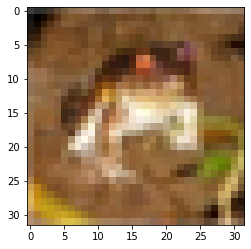

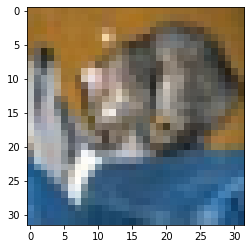

In [4]:
img1 = transforms.ToPILImage()(train[0][0])
plt.imshow(img1)
plt.show()
img2 = transforms.ToPILImage()(val[0][0])
plt.imshow(img2)
plt.show()

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train, batch_size=50)
val_loader = torch.utils.data.DataLoader(dataset=val, batch_size=50)

In [6]:
l2_lambda = 0.00025

def closure_cifar(net_input, true_labels):
    out_labels = net_cifar.forward(net_input)

    total_loss = loss_type(out_labels, true_labels)
    l2_reg = torch.tensor(0.).to(device)
    for param in net_cifar.parameters():
        l2_reg += torch.norm(param)**2
    total_loss += l2_lambda * l2_reg

    total_loss.backward()
    
    return total_loss

def num_correct(pred_labels, true_labels):
    return (pred_labels==true_labels).sum()

def evaluate(data_loader):
    net_cifar.eval()
    total_correct, total_evaluated = 0, 0
    for data, labels in data_loader:
        pred_labels = net_cifar(data.to(device))
        nc = num_correct(pred_labels, labels.data.numpy())
        total_correct += nc
        total_evaluated += len(labels)
    return total_correct / total_evaluated * 100

In [7]:
def optimize2(optimizer_type, parameters, closure, LR, num_epochs):
    """Runs optimization loop.

    Args:
        optimizer_type: 'LBFGS' of 'adam'
        parameters: list of Tensors to optimize over
        closure: function, that returns loss variable
        LR: learning rate
        num_iter: number of iterations 
    """
    if optimizer_type == 'adam':
        print('Starting optimization with ADAM')
        optimizer = torch.optim.Adam(parameters, lr=LR)
        
        for j in range(num_epochs):
            net_cifar.train()
            epoch_loss = 0
            for data, labels in train_loader:
                optimizer.zero_grad()
                loss = closure_cifar(data.to(device), labels.to(device))
                optimizer.step()
                epoch_loss += loss
            print("Epoch %d: loss=%f; train_acc=%f%%; val_acc=%f%%"%(j+1, epoch_loss.detach(), evaluate(train_loader), evaluate(val_loader)))
    else:
        assert False

In [8]:
# net_cifar = UNetCIFAR()
# net_cifar.to(device)
# optimize2('adam', net_cifar.parameters(), closure_cifar, 1e-3, 100)

In [9]:
# pickle.dump(net, open("model_pickles/cifar10_unet_reg.pickle", "wb"))

In [10]:
net_cifar = pickle.load(open("model_pickles/cifar10_unet_reg.pickle", "rb"))
net_cifar.to(device)

UNetCIFAR(
  (start): unetConv2(
    (conv1): Sequential(
      (0): Sequential(
        (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
    (conv2): Sequential(
      (0): Sequential(
        (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      )
      (1): InstanceNorm2d(16, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
      (2): ReLU()
    )
  )
  (down1): unetDown(
    (conv): unetConv2(
      (conv1): Sequential(
        (0): Sequential(
          (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        )
        (1): InstanceNorm2d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
        (2): ReLU()
      )
      (conv2): Sequential(
        (0): Sequential(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        

In [11]:
print("Accuracy: train=%.4f%%; validation=%.4f%%"%(evaluate(train_loader), evaluate(val_loader)))

Accuracy: train=94.3440%; validation=71.8100%


In [12]:
def fgsm_batch(data, epsilon=0.01):
    data_perturbed = data + torch.sign(data.grad)*epsilon
    return data_perturbed

def noisy_batch(data, epsilon=0.01):
    noise = torch.sign(torch.randn_like(data))*epsilon
    return data + noise

Accuracy: clean=71.8100%; noisy=71.5700%; perturbed=2.7800%


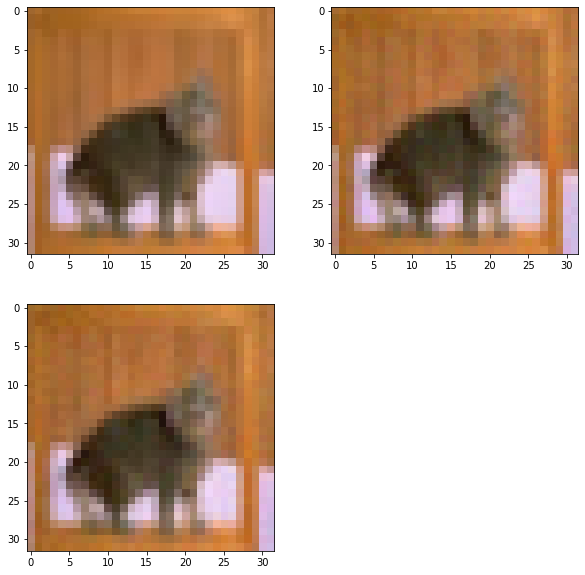

In [13]:
net_cifar.eval()
nc_clean = 0
nc_noisy = 0
nc_perturbed = 0
epsilon = 0.015
for data, labels in val_loader:
    data, labels = data.to(device), labels.to(device)

    pred_labels = net_cifar(data)
    nc_clean += num_correct(pred_labels, labels.data.cpu().numpy())

    data_noisy = noisy_batch(data, epsilon=epsilon)
    pred_labels = net_cifar(data_noisy)
    nc_noisy += num_correct(pred_labels, labels.data.cpu().numpy())

    data.requires_grad = True

    loss_val = closure_cifar(data, labels)

    data_perturbed = fgsm_batch(data, epsilon=epsilon)

    pred_labels = net_cifar(data_perturbed)
    nc_perturbed += num_correct(pred_labels, labels.data.cpu().numpy())

n = len(val)
print("Accuracy: clean=%.4f%%; noisy=%.4f%%; perturbed=%.4f%%"%(nc_clean/n*100, nc_noisy/n*100, nc_perturbed/n*100))
img1 = transforms.ToPILImage()(data[0])
img2 = transforms.ToPILImage()(data_noisy[0])
img3 = transforms.ToPILImage()(data_perturbed[0])

fig = plt.figure(figsize=(10, 10))
ax1 = fig.add_subplot(221)
ax1.imshow(img1)
ax2 = fig.add_subplot(222)
ax2.imshow(img2)
ax3 = fig.add_subplot(223)
ax3.imshow(img3)
plt.show()

## Resisting Adversarial

In [14]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 0 # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 100
exp_weight=0.99

input_depth = 32 
figsize = 4 


net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=3,
              upsample_mode='bilinear').type(dtype)

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

Number of params: 1286463


In [15]:
def denoise_one(img_torch):
    global i, net, net_input, out_avg, img_noisy_pil, img_noisy_np, img_noisy_torch, img_np, psrn_noisy_last

    net = get_net(input_depth, 'skip', pad,
              skip_n33d=128, 
              skip_n33u=128, 
              skip_n11=4, 
              num_scales=3,
              upsample_mode='bilinear').type(dtype)

    img_noisy_torch = img_torch
    img_pil = transforms.ToPILImage()(img_noisy_torch)
    img_np = pil_to_np(img_pil)
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)

    net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

    net_input_saved = net_input.detach().clone()
    noise = net_input.detach().clone()
    out_avg = None
    last_net = None
    psrn_noisy_last = 0

    i = 0
    p = get_params(OPT_OVER, net, net_input)
    optimize(OPTIMIZER, p, closure, LR, num_iter)
    return net(net_input)

Starting optimization with ADAM


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3063: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))
/usr/local/lib/python3.7/dist-packages/torch/nn/modules/loss.py:446: UserWarning: Using a target size (torch.Size([3, 32, 32])) that is different to the input size (torch.Size([1, 3, 32, 32])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


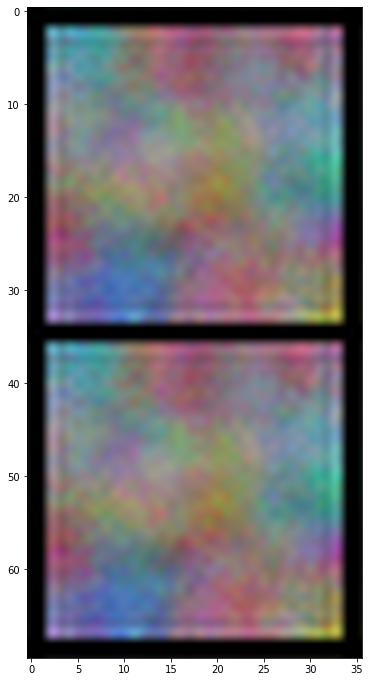

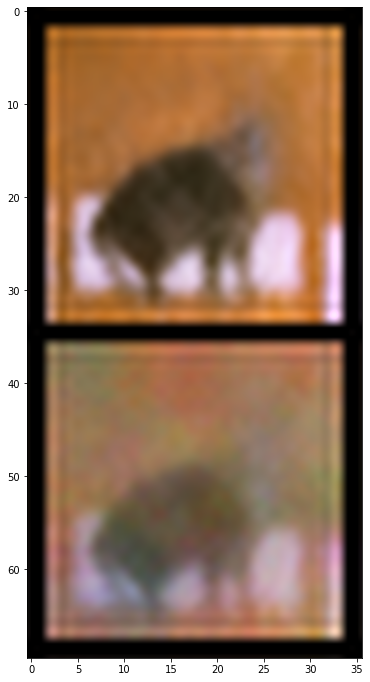

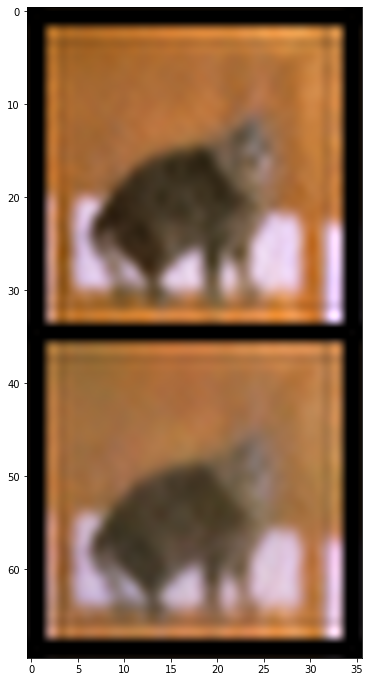

In [16]:
sigma_ = 0 #The perturbation is the "noise"...

imsize =-1
PLOT = True

def closure():
    
    global i, out_avg, psrn_noisy_last, last_net, net_input
    
    if reg_noise_std > 0:
        net_input = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
    
    # Smoothing
    if out_avg is None:
        out_avg = out.detach()
    else:
        out_avg = out_avg * exp_weight + out.detach() * (1 - exp_weight)
            
    total_loss = mse(out, img_noisy_torch)
    total_loss.backward()
    
    psrn_noisy = compare_psnr(img_noisy_np, out.detach().cpu().numpy()[0]) 
    psrn_gt    = compare_psnr(img_np, out.detach().cpu().numpy()[0]) 
    psrn_gt_sm = compare_psnr(img_np, out_avg.detach().cpu().numpy()[0]) 
    
    # Note that we do not have GT for the "snail" example
    # So 'PSRN_gt', 'PSNR_gt_sm' make no sense
    print ('Iteration %05d    Loss %f   PSNR_noisy: %f   PSRN_gt: %f PSNR_gt_sm: %f' % (i, total_loss.item(), psrn_noisy, psrn_gt, psrn_gt_sm), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = torch_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1), 
                         np.clip(torch_to_np(out_avg), 0, 1)], factor=figsize, nrow=1)
        
    # Backtracking
    if i % show_every:
        if psrn_noisy - psrn_noisy_last < -5: 
            print('Falling back to previous checkpoint.')

            for new_param, net_param in zip(last_net, net.parameters()):
                net_param.data.copy_(new_param.cuda())

            return total_loss*0
        else:
            last_net = [x.detach().cpu() for x in net.parameters()]
            psrn_noisy_last = psrn_noisy
            
    i += 1

    return total_loss

num_iter = 300
img3_denoise = denoise_one(data_perturbed[0])

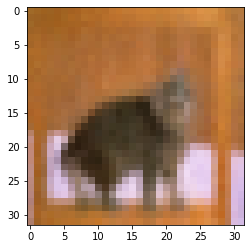

In [17]:
img3_denoise_pil = transforms.ToPILImage()(img3_denoise.squeeze())
plt.imshow(img3_denoise_pil)
plt.show()

In [18]:
# torch.manual_seed(0)

# num_iter = 35
# purified_batch = []
# PLOT = False
# for j in range(data_perturbed.shape[0]):
#     print("Purifying image %d"%(j))
#     purified_batch.append(denoise_one(data_perturbed[j]))

In [19]:
# img3_denoise_pil = transforms.ToPILImage()(purified_batch[3].squeeze())
# plt.imshow(img3_denoise_pil)
# plt.show()

In [20]:
# purified = torch.stack([x.squeeze() for x in purified_batch], dim=0)
# purified.shape

In [21]:
# pred_labels = net_cifar(purified)
# nc = num_correct(pred_labels, labels.data.cpu().numpy())
# nc

In [22]:
# num_iter = 200
# remade_clean = []
# PLOT = False
# for j in range(data.shape[0]):
#     print("Remaking image %d"%(j))
#     remade_clean.append(denoise_one(data[j]))

In [23]:
# img3_denoise_pil = transforms.ToPILImage()(remade_clean[3].squeeze())
# plt.imshow(img3_denoise_pil)
# plt.show()

In [24]:
# purified = torch.stack([x.squeeze() for x in remade_clean], dim=0)
# purified.shape

In [25]:
# pred_labels = net_cifar(purified)
# nc = num_correct(pred_labels, labels.data.cpu().numpy())
# nc

In [26]:
# num_iter = 200
# remade_noisy = []
# PLOT = False
# for j in range(data_noisy.shape[0]):
#     print("Remaking image %d"%(j))
#     remade_noisy.append(denoise_one(data_noisy[j]))

In [27]:
# purified = torch.stack([x.squeeze() for x in remade_noisy], dim=0)
# purified.shape

In [28]:
# pred_labels = net_cifar(purified)
# nc = num_correct(pred_labels, labels.data.cpu().numpy())
# nc